
# Phân tích doanh thu và hiệu suất bán hàng
- Tổng doanh thu theo ngày, tuần, tháng, xác định ngày nào trong tuần bán chạy nhất của tất cả cửa hàng và của từng cửa hàng.
- So sánh hiệu suất bán hàng của từng cửa hàng
- Phân tích tác động của giảm giá (số lượng bán ra và doanh thu trước và sau giảm giá)

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import sys
import os
sys.path.append('../../../scripts/')
import data_cleaning

# 1. Import data
Nhập dữ liệu đã qua xử lý, data đã clean 20240722

In [53]:
df_menuitem = pd.read_csv("../../../data/processed/20240722/2.menuitem_20240722.csv")
df_menuitem.head()

,MD5KEY_MENUITEM,MD5KEY_ORDERSALE,CategoryDescription,DepartmentDescription,Description,StoreNumber,TaxAmount,AdjustedPrice,DiscountAmount,Price,Quantity,PLU,Id,date,SalesAmount,day_of_week
0,001E0224E4EDA63D6FED96D59E0C1E76,072D3B76BE58E4553A373AF3206D2CA5,Footlong,Footlong Sub,Chickn Strips FtLong,46673,0.6975,7.75,0.00,7.75,1,111000041,326,2015-03-05,7.75,Thursday
1,003E4E20196B2F5BDD33CE06D2943EF4,14811D4F3458058007B0B6908C2DA393,Fountain,Fountain Drink 21 oz.,21oz Fountain Drink,46673,0.1530,1.70,0.00,1.70,1,212000126,280,2015-03-05,1.70,Thursday
2,012A55E5551C95A559A7B074AE85117E,22FA6C39B7A15ABB6EB568E66A6B30E1,6 Inch,6 Inch Sub,B.M.T. 6 inch,12631,0.3230,3.64,0.61,4.25,1,121000008,8,2015-03-05,3.64,Thursday
3,01B07F1C6DC6945796571FC78735DA16,915B69612845BBD974C39AC105F5CA8C,6 Inch,6 Inch Sub,Veggie Delite 6 inch,12631,0.3328,3.75,0.00,3.75,1,121000001,91,2015-03-05,3.75,Thursday
4,02DE19974DE5304BF243A1C2EC639495,CD6386C802450EDCF13A3D112D1F86EC,Add On,Add On 6in Portion,Avocado Add6in,12631,0.0443,0.50,0.00,0.50,1,175000062,564,2015-03-05,0.50,Thursday


In [54]:
df_ordersale = pd.read_csv("../../../data/processed/20240722/1.pos_ordersale_20240722.csv")
df_ordersale.head()

,MD5KEY_ORDERSALE,ChangeReceived,OrderNumber,TaxAmount,MealLocation,TransactionId,StoreNumber,date
0,00BCB738A1F814DB960C25012E9913DF,0.00,67,0.56,0,67,46673,2015-03-05
1,03438C257BC2DD0037F35EC8BFC0C8E2,3.46,39,0.54,0,39,12631,2015-03-05
2,04AEF56CF3130AC1EFAD41C470F5245D,0.00,81,0.69,0,79,46673,2015-03-05
3,04BBFAD4E73C30EE2EC3B4E52509637C,0.00,159,1.16,0,159,12631,2015-03-05
4,061AE382DC127057E8ADBBF869CFB361,0.00,51,0.00,0,51,12631,2015-03-05


# 2. Phân tích doanh thu ngày và ngày trong tuần
Phân tích doanh thu thao ngày, ngày trong tuần để hiểu rõ hơn về xu hướng doanh thu của tổng quan và của từng cửa hàng.

## 2.1 Doanh thu
Để phân tích doanh cần các trường trong file menuitem:
- SalesAmount
- date
- day_of_week

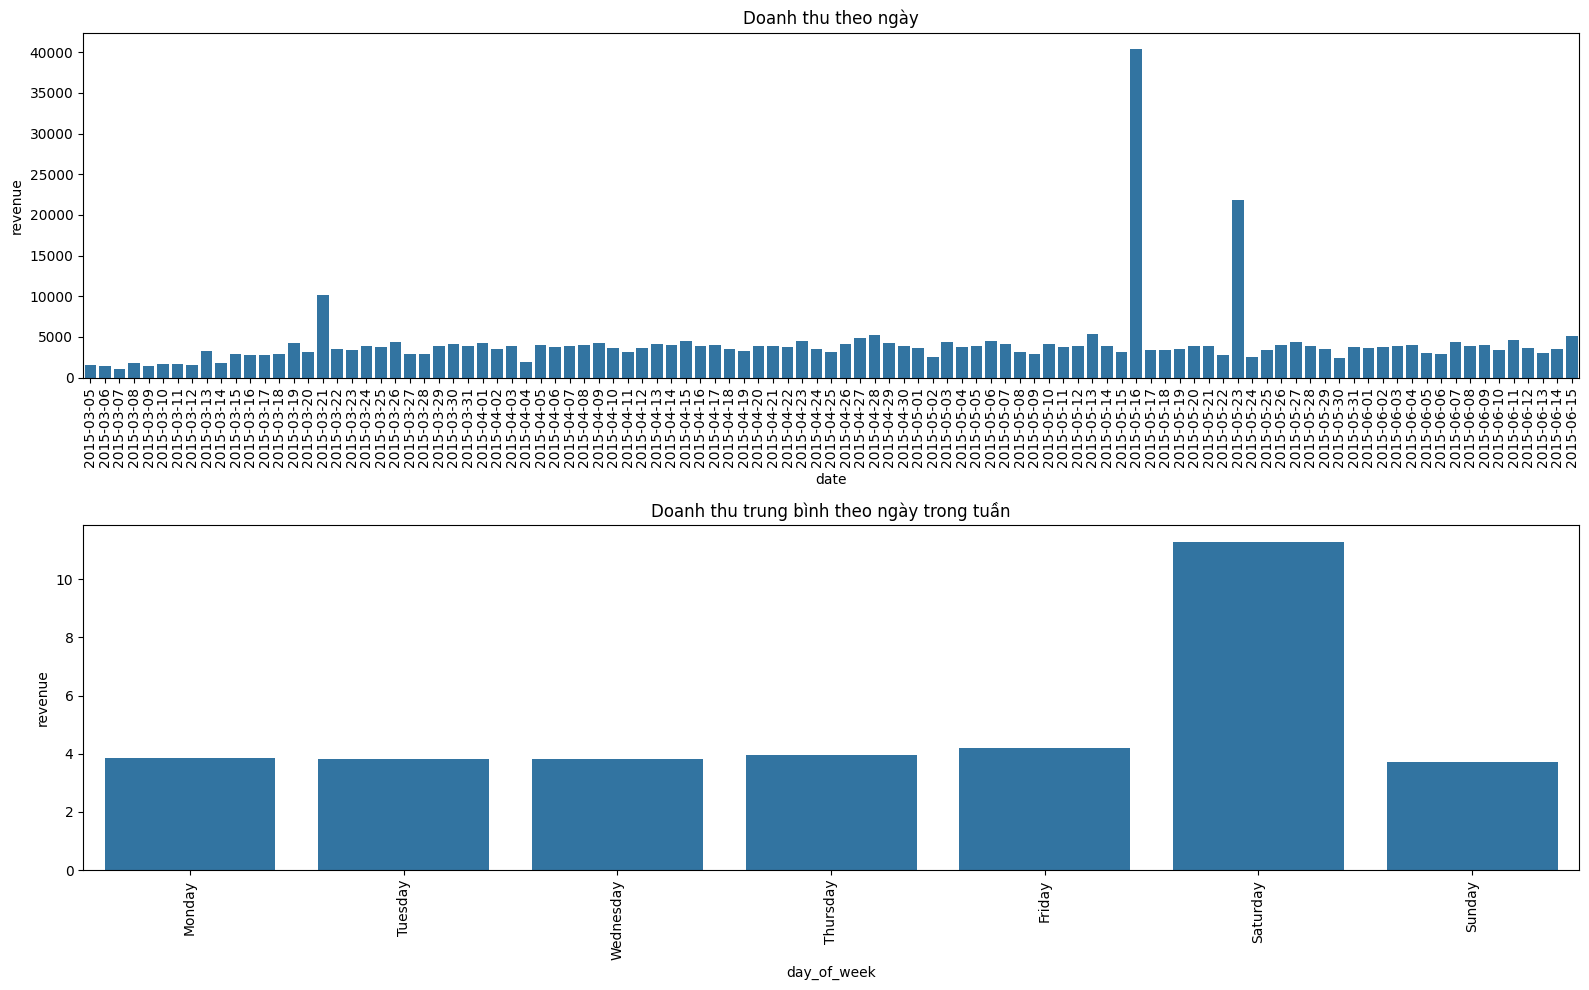

In [111]:
plt.figure(figsize=(16, 10))

plt.subplot(2, 1, 1)
sns.barplot(data=df_menuitem.groupby('date').agg(revenue=('SalesAmount', 'sum')),
             x='date',
             y='revenue')
plt.xticks(rotation=90, ha='center')
plt.title("Doanh thu theo ngày")

plt.subplot(2, 1, 2)
sns.barplot(data=df_menuitem.groupby('day_of_week').agg(revenue=('SalesAmount', 'mean')),
             x='day_of_week',
             y='revenue',
             order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xticks(rotation=90, ha='center')
plt.title("Doanh thu trung bình theo ngày trong tuần")

plt.tight_layout()
plt.show()

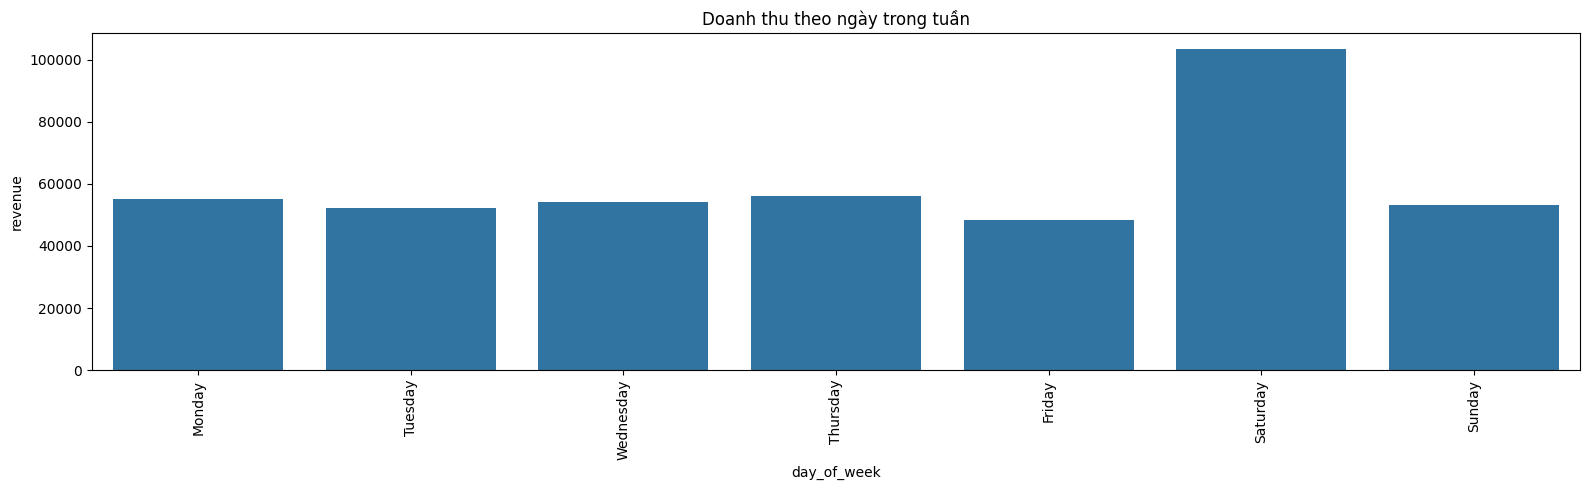

In [123]:
plt.figure(figsize=(16, 5))

sns.barplot(data=df_menuitem.groupby('day_of_week').agg(revenue=('SalesAmount', 'sum')),
             x='day_of_week',
             y='revenue',
             order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xticks(rotation=90, ha='center')
plt.title("Doanh thu theo ngày trong tuần")

plt.tight_layout()
plt.show()

### Check các ngày doanh thu đột biến là thứ mấy

In [56]:
print(df_menuitem[df_menuitem['date'] == '2015-03-21'].loc[:, 'day_of_week'].unique())
print(df_menuitem[df_menuitem['date'] == '2015-05-16'].loc[:, 'day_of_week'].unique())
print(df_menuitem[df_menuitem['date'] == '2015-05-23'].loc[:, 'day_of_week'].unique())

['Saturday']
['Saturday']
['Saturday']


### 2.1.1 Tách outliers Quantity

In [57]:
# Tính Q1_quantity (25th percentile) và Q3_Quantity (75th percentile)
Q1_quantity = df_menuitem['Quantity'].quantile(0.25)
Q3_quantity = df_menuitem['Quantity'].quantile(0.75)

# Tính IQR_quantity
IQR_quantity = Q3_quantity - Q1_quantity

# Xác định giới hạn dưới và trên
lower_bound_quantity = Q1_quantity - 1.5 * IQR_quantity
upper_bound_quantity = Q3_quantity + 1.5 * IQR_quantity

# Xác định giá trị ngoại lai
outliers_quantity = df_menuitem[(df_menuitem['Quantity'] < lower_bound_quantity) | (df_menuitem['Quantity'] > upper_bound_quantity)].copy()
non_outliers_quantity = df_menuitem[~((df_menuitem['Quantity'] < lower_bound_quantity) | (df_menuitem['Quantity'] > upper_bound_quantity))].copy()

In [58]:
print("Số hàng menuitem:", df_menuitem.shape[0])
print("Tổng hàng outliers và non_outliers:", outliers_quantity.shape[0] + non_outliers_quantity.shape[0])
print("% outliers:", outliers_quantity.shape[0] / df_menuitem.shape[0] * 100)
print("Số hàng outliers:", outliers_quantity.shape[0])
print("Số hàng non_outliers:", non_outliers_quantity.shape[0])

Số hàng menuitem: 91420
Tổng hàng outliers và non_outliers: 91420
% outliers: 7.5082038941150735
Số hàng outliers: 6864
Số hàng non_outliers: 84556


### 2.1.2 Doanh thu tổng non_outliers

In [59]:
# Doanh thu tổng theo ngày
revenue_by_day = non_outliers_quantity.groupby(['date', 'day_of_week']).agg(revenue=('SalesAmount', 'sum')).reset_index()

# Doanh thu tổng ngày trong tuần
revenue_day_of_week = revenue_by_day.groupby('day_of_week').agg(revenue=('revenue', 'mean')).sort_values(by='revenue').reset_index()


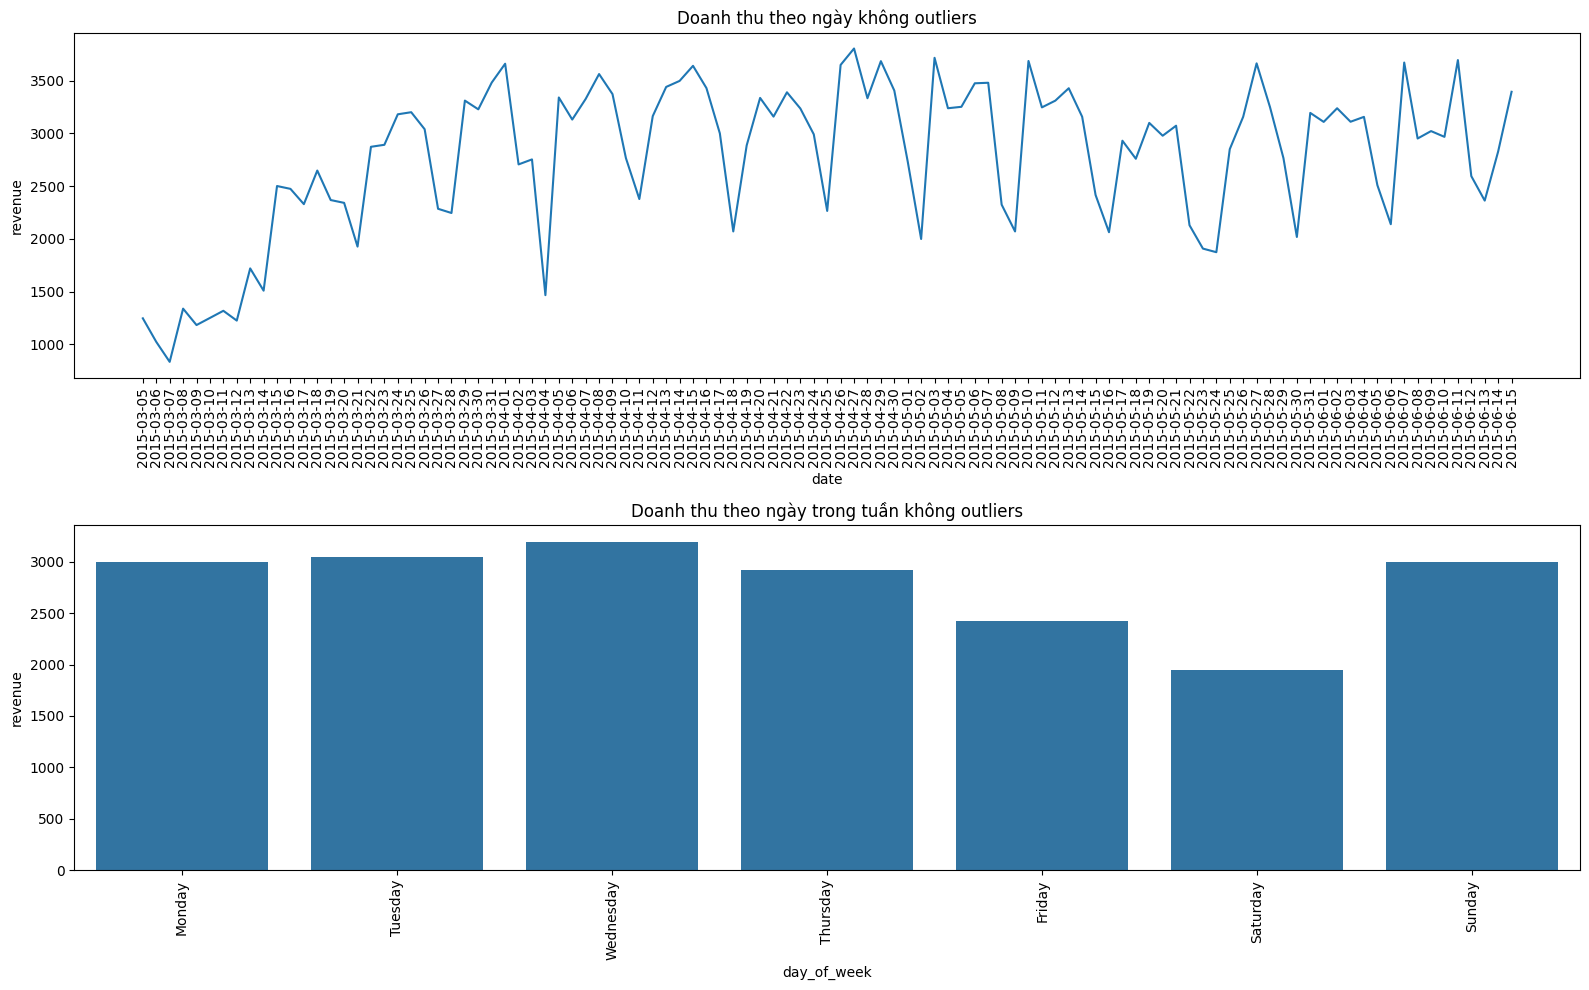

In [60]:
plt.figure(figsize=(16, 10))

plt.subplot(2, 1, 1)
sns.lineplot(data=revenue_by_day,
             x='date',
             y='revenue')
plt.xticks(rotation=90, ha='center')
plt.title("Doanh thu theo ngày không outliers")

plt.subplot(2, 1, 2)
sns.barplot(data=revenue_day_of_week,
             x='day_of_week',
             y='revenue',
             order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xticks(rotation=90, ha='center')
plt.title("Doanh thu theo ngày trong tuần không outliers")

plt.tight_layout()
plt.show()

Note: Khoảng thời gian 2 tuần đầu hơi ít so với khoảng thời gian còn lại.
- Data có vấn đề gì không? (Không đủ dữ liệu để tìm nguyên nhân)
- Biểu đồ doanh thu theo ngày có tính chu kỳ, dựa theo biểu đồ doanh thu ngày trong tuần xác định điều đó

Nhận xét: Doanh thu có xu hướng tăng từ thứ 2 tới ths 4 và có xu hướng giảm từ thứ 5 tới thứ 7 và tăng trở lại vào CN

#### 2.1.2.1 Kiểm tra dữ liệu

In [61]:
revenue_by_day

,date,day_of_week,revenue
0,2015-03-05,Thursday,1246.79
1,2015-03-06,Friday,1023.68
2,2015-03-07,Saturday,834.16
3,2015-03-08,Sunday,1338.52
4,2015-03-09,Monday,1183.01
...,...,...,...
98,2015-06-11,Thursday,3693.93
99,2015-06-12,Friday,2594.26
100,2015-06-13,Saturday,2362.31
101,2015-06-14,Sunday,2827.45


In [62]:
revenue_day_of_week

,day_of_week,revenue
0,Saturday,1949.969333
1,Friday,2423.059333
2,Thursday,2921.995333
3,Sunday,2996.866667
4,Monday,3001.897333
5,Tuesday,3044.854286
6,Wednesday,3193.961429


### 2.1.3 Doanh thu tổng outliers

In [63]:
# Doanh thu tổng theo ngày
revenue_by_day_outliers = outliers_quantity.groupby(['date', 'day_of_week']).agg(revenue=('SalesAmount', 'sum')).reset_index()

# Doanh thu tổng ngày trong tuần
revenue_day_of_week_outliers = revenue_by_day_outliers.groupby('day_of_week').agg(revenue=('revenue', 'mean')).sort_values(by='revenue').reset_index()

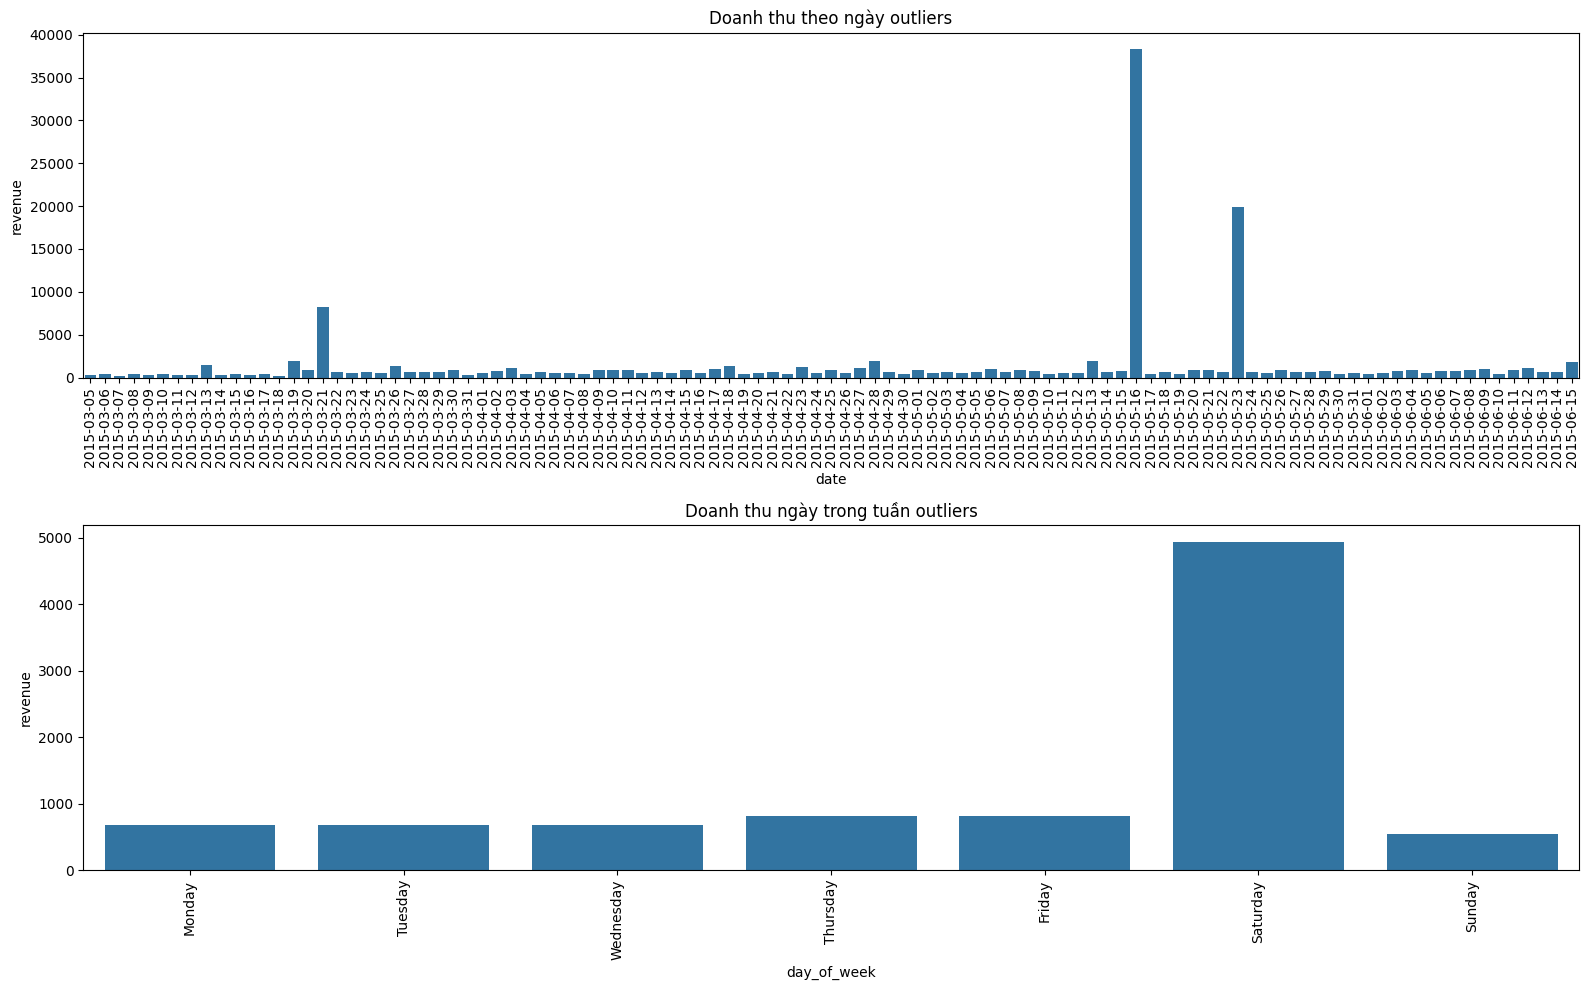

In [64]:
plt.figure(figsize=(16, 10))

plt.subplot(2, 1, 1)
sns.barplot(data=revenue_by_day_outliers,
             x='date',
             y='revenue')
plt.xticks(rotation=90, ha='center')
plt.title("Doanh thu theo ngày outliers")

plt.subplot(2, 1, 2)
sns.barplot(data=revenue_day_of_week_outliers,
             x='day_of_week',
             y='revenue',
             order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xticks(rotation=90, ha='center')
plt.title("Doanh thu ngày trong tuần outliers")

plt.tight_layout()
plt.show()

Note: (giả thuyết)
- Thứ 7 có nhiều outliers
- Có thể thứ 7 khách nhỏ giảm khách lớn tăng 
Note: Outliers thường vào ngày thứ 7 cho thấy có thể có những sự kiện đặc biệt diễn ra trong ngày này như: đặt tiệc, sự kiện, hoặc các chương trình khuyến mãi đặc biệt

Analysis: Để xác nhận giả thuyết này, cần phân tích thêm dữ liệu về số lượng đơn hàng, doanh thu mỗi đơn hàng, và loại hình (ăn tại chỗ hoặc mang đi) được sử dụng vào các ngày thứ 7.

#### 2.1.3.1 Kiểm tra và xác nhận lại dữ liệu ngoại lai

In [65]:
revenue_by_day_outliers.head()

,date,day_of_week,revenue
0,2015-03-05,Thursday,312.00
1,2015-03-06,Friday,404.60
2,2015-03-07,Saturday,201.45
3,2015-03-08,Sunday,435.66
4,2015-03-09,Monday,257.48


In [66]:
revenue_day_of_week_outliers

,day_of_week,revenue
0,Sunday,550.019333
1,Tuesday,675.612857
2,Monday,676.065333
3,Wednesday,682.364286
4,Friday,808.228667
5,Thursday,813.735333
6,Saturday,4941.661333


### 2.1.4 Xác nhận giả thuyết sang phần 2.2
Để xác nhận giả thuyết từ 2.1.3 khi thứ 7 dữ liệu ngoại lại nhiều, cần phân tích thêm dữ liệu về:
- Doanh thu trung bình mỗi đơn hàng
- Số lượng đơn hàng
- Trung bình món ăn mỗi đơn hàng
- Loại hình (ăn tại chỗ hoặc mang đi) được sử dụng vào các ngày thứ 7.

## 2.2 Kiểm tra dữ liệu thứ 7 so với các ngày khác trong tuần
Cần dữ liệu từ ordersale và menuitem để lấy được loại hình ăn uống (tại chỗ, mang đi)

### 2.2.1 Chuẩn bị dữ liệu

#### 2.2.1.1 Merge dữ liệu

In [67]:
df_ordersale

,MD5KEY_ORDERSALE,ChangeReceived,OrderNumber,TaxAmount,MealLocation,TransactionId,StoreNumber,date
0,00BCB738A1F814DB960C25012E9913DF,0.00,67,0.56,0,67,46673,2015-03-05
1,03438C257BC2DD0037F35EC8BFC0C8E2,3.46,39,0.54,0,39,12631,2015-03-05
2,04AEF56CF3130AC1EFAD41C470F5245D,0.00,81,0.69,0,79,46673,2015-03-05
3,04BBFAD4E73C30EE2EC3B4E52509637C,0.00,159,1.16,0,159,12631,2015-03-05
4,061AE382DC127057E8ADBBF869CFB361,0.00,51,0.00,0,51,12631,2015-03-05
...,...,...,...,...,...,...,...,...
43223,FBEFF26C8C626C303C191A42C8CCFBDA,0.00,8014,1.58,0,8014,20974,2015-06-15
43224,FC277A831486F1ADD27AE22FF2BDF559,0.03,15972,0.47,0,15972,4904,2015-06-15
43225,FD23743074BCCB6E0847269D09F458AE,0.00,16014,0.00,1,16014,4904,2015-06-15
43226,FD570797AC0A9AFC3953A30EC5355829,0.00,7149,0.00,1,7149,46673,2015-06-15


In [68]:
df_menuitem.columns

Index(['MD5KEY_MENUITEM', 'MD5KEY_ORDERSALE', 'CategoryDescription',
       'DepartmentDescription', 'Description', 'StoreNumber', 'TaxAmount',
       'AdjustedPrice', 'DiscountAmount', 'Price', 'Quantity', 'PLU', 'Id',
       'date', 'SalesAmount', 'day_of_week'],
      dtype='object')

In [69]:
# Merge dữ liệu ordersale và menuitem
merged_ordersale_menuitem = pd.merge(df_ordersale, df_menuitem, on='MD5KEY_ORDERSALE', how='left')
merged_ordersale_menuitem.head()

,MD5KEY_ORDERSALE,ChangeReceived,OrderNumber,TaxAmount_x,MealLocation,TransactionId,StoreNumber_x,date_x,MD5KEY_MENUITEM,CategoryDescription,...,TaxAmount_y,AdjustedPrice,DiscountAmount,Price,Quantity,PLU,Id,date_y,SalesAmount,day_of_week
0,00BCB738A1F814DB960C25012E9913DF,0.00,67,0.56,0,67,46673,2015-03-05,F723AFAEC05500ED00EE7B642DBBEF50,Fountain,...,0.1530,1.70,0.0,1.70,1.0,212000126.0,280.0,2015-03-05,1.70,Thursday
1,00BCB738A1F814DB960C25012E9913DF,0.00,67,0.56,0,67,46673,2015-03-05,FBDE984CE2674869B840D31AE7E4C35A,6 Inch,...,0.4050,4.50,0.0,4.50,1.0,121000004.0,2.0,2015-03-05,4.50,Thursday
2,03438C257BC2DD0037F35EC8BFC0C8E2,3.46,39,0.54,0,39,12631,2015-03-05,6B19A97889A7B5902E6E7B489F403067,6 Inch,...,0.3771,4.25,0.0,4.25,1.0,121000006.0,75.0,2015-03-05,4.25,Thursday
3,03438C257BC2DD0037F35EC8BFC0C8E2,3.46,39,0.54,0,39,12631,2015-03-05,B54026720FF6611399B7451FCC8DC4B2,Bottled Beverage,...,0.1553,1.75,0.0,1.75,1.0,221000135.0,278.0,2015-03-05,1.75,Thursday
4,04AEF56CF3130AC1EFAD41C470F5245D,0.00,81,0.69,0,79,46673,2015-03-05,BC939C43F3BEB1DCE24AAD956919832C,Bottled Beverage,...,0.1710,1.90,0.0,1.90,1.0,221000134.0,365.0,2015-03-05,1.90,Thursday


In [70]:
# Kiểm tra doanh thu tổng trước và sau merge 
print(df_menuitem['SalesAmount'].sum())
print(merged_ordersale_menuitem['SalesAmount'].sum())

422607.57
422607.57


#### 2.2.1.2 Groupby dữ liệu theo đơn hàng

In [71]:
merged_ordersale_menuitem.columns

Index(['MD5KEY_ORDERSALE', 'ChangeReceived', 'OrderNumber', 'TaxAmount_x',
       'MealLocation', 'TransactionId', 'StoreNumber_x', 'date_x',
       'MD5KEY_MENUITEM', 'CategoryDescription', 'DepartmentDescription',
       'Description', 'StoreNumber_y', 'TaxAmount_y', 'AdjustedPrice',
       'DiscountAmount', 'Price', 'Quantity', 'PLU', 'Id', 'date_y',
       'SalesAmount', 'day_of_week'],
      dtype='object')

In [72]:
# Group các trường cần thiết để tính doanh thu, số lượng đơn hàng, loại hình
merged_ordersale_menuitem_groupby = merged_ordersale_menuitem.groupby(['MD5KEY_ORDERSALE', 'date_x', 'day_of_week', 'StoreNumber_x', 'MealLocation']).agg(
  Quantity=('Quantity', 'sum'),
  SalesAmount=('SalesAmount', 'sum')
).reset_index()

merged_ordersale_menuitem_groupby

,MD5KEY_ORDERSALE,date_x,day_of_week,StoreNumber_x,MealLocation,Quantity,SalesAmount
0,00040FB2079EE37A1A3347134FDA1222,2015-04-03,Friday,12631,0,1.0,6.00
1,000487D84122ECFC7C2B0681D7847D07,2015-04-03,Friday,12631,0,4.0,28.40
2,0006541E961609F6EA9B93AF996791FA,2015-03-19,Thursday,4904,1,1.0,4.25
3,0007198A6EA115A618FB1F7A47DA5A94,2015-04-16,Thursday,12631,0,1.0,6.00
4,0009AF6BC70525EA7865AB795C651219,2015-04-22,Wednesday,12631,0,2.0,0.00
...,...,...,...,...,...,...,...
40616,FFF4B340CBD214BD2A0C12944DD6FC4C,2015-04-25,Saturday,4904,1,1.0,5.50
40617,FFF4B38DC800DE5784EC2F27909AB4B9,2015-04-09,Thursday,46673,0,3.0,9.25
40618,FFF9C0AFD57C0B07E3ADE021C41BC222,2015-03-21,Saturday,4904,0,1.0,6.75
40619,FFFB7296078113301047E98795ED0836,2015-04-28,Tuesday,4904,1,3.0,6.00


### 2.2.2 Doanh thu trung bình mỗi đơn hàng

In [73]:
# Group by date
groupby_day_revenue = merged_ordersale_menuitem_groupby.groupby(['date_x', 'day_of_week']).agg(revenue=('SalesAmount', 'mean')).reset_index()

# Group day_of_week
groupby_day_of_week_revenue = groupby_day_revenue.groupby('day_of_week').agg(avg_revenue=('revenue', 'mean')).reset_index()

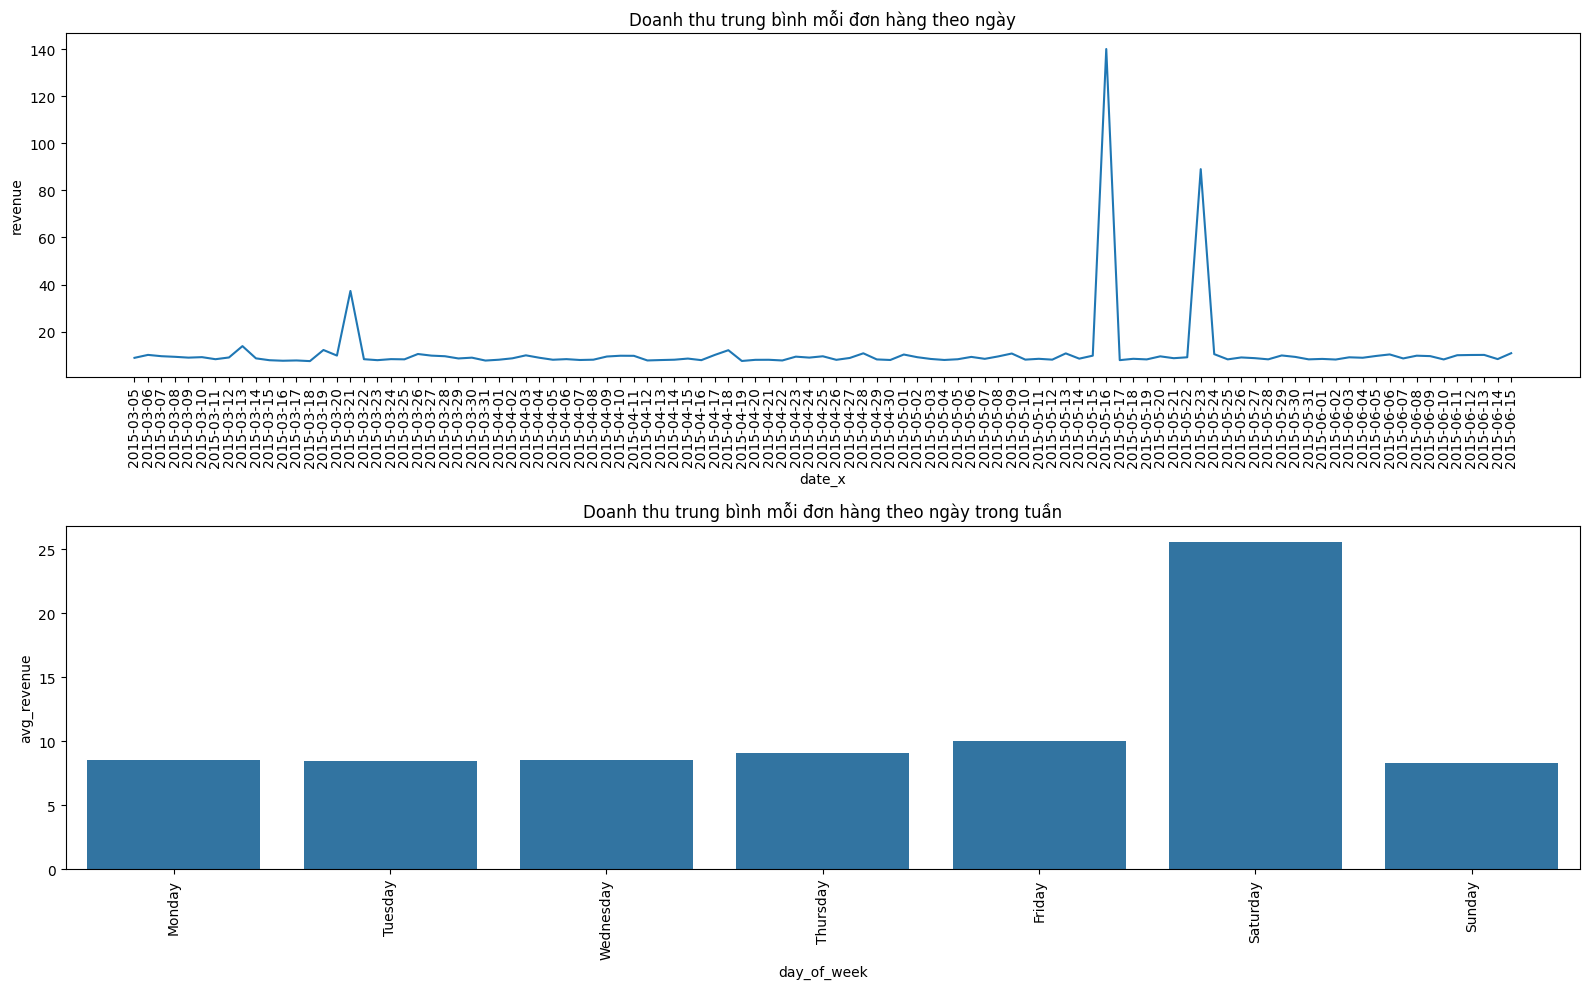

In [74]:
plt.figure(figsize=(16, 10))

plt.subplot(2, 1, 1)
sns.lineplot(data=groupby_day_revenue,
             x='date_x',
             y='revenue')
plt.xticks(rotation=90, ha='center')
plt.title("Doanh thu trung bình mỗi đơn hàng theo ngày")

plt.subplot(2, 1, 2)
sns.barplot(data=groupby_day_of_week_revenue,
             x='day_of_week',
             y='avg_revenue',
             order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xticks(rotation=90, ha='center')
plt.title("Doanh thu trung bình mỗi đơn hàng theo ngày trong tuần")

plt.tight_layout()
plt.show()

### 2.2.3 Số lượng đơn hàng

In [75]:
merged_ordersale_menuitem_groupby.head()

,MD5KEY_ORDERSALE,date_x,day_of_week,StoreNumber_x,MealLocation,Quantity,SalesAmount
0,00040FB2079EE37A1A3347134FDA1222,2015-04-03,Friday,12631,0,1.0,6.00
1,000487D84122ECFC7C2B0681D7847D07,2015-04-03,Friday,12631,0,4.0,28.40
2,0006541E961609F6EA9B93AF996791FA,2015-03-19,Thursday,4904,1,1.0,4.25
3,0007198A6EA115A618FB1F7A47DA5A94,2015-04-16,Thursday,12631,0,1.0,6.00
4,0009AF6BC70525EA7865AB795C651219,2015-04-22,Wednesday,12631,0,2.0,0.00


In [76]:
# Group by date
groupby_day_order = merged_ordersale_menuitem_groupby.groupby(['date_x', 'day_of_week']).agg(total_order=('MD5KEY_ORDERSALE', 'count')).reset_index()

# Group day_of_week
groupby_day_of_week_order = groupby_day_order.groupby('day_of_week').agg(avg_order=('total_order', 'mean')).reset_index()

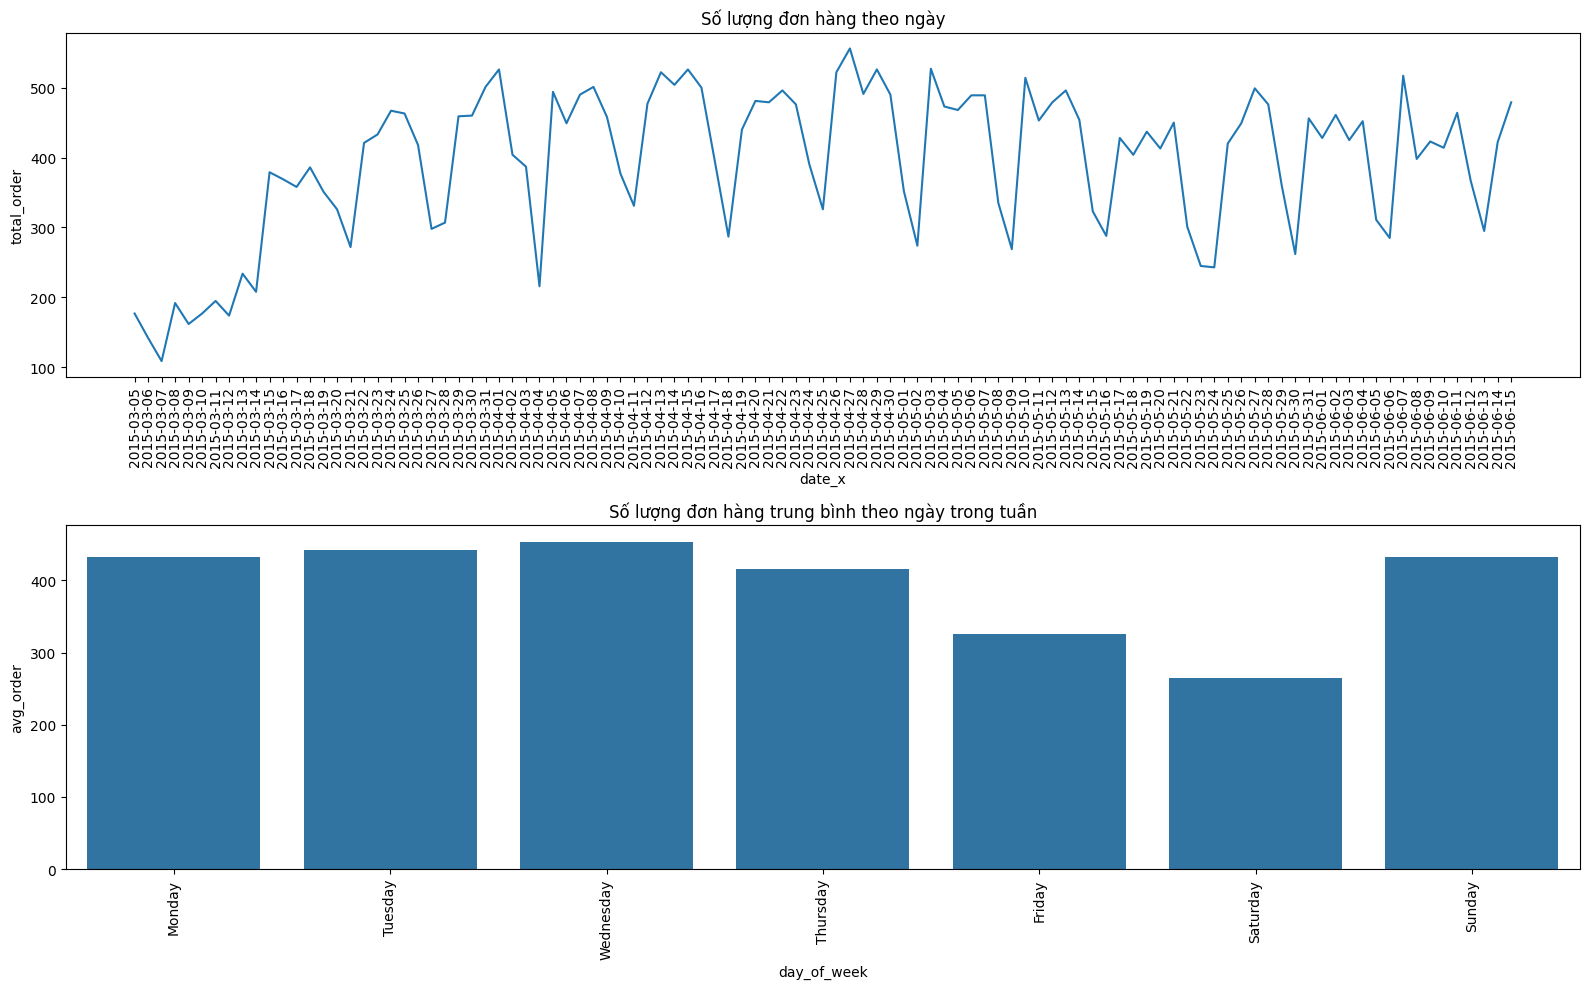

In [77]:
plt.figure(figsize=(16, 10))

plt.subplot(2, 1, 1)
sns.lineplot(data=groupby_day_order,
             x='date_x',
             y='total_order')
plt.xticks(rotation=90, ha='center')
plt.title("Số lượng đơn hàng theo ngày")

plt.subplot(2, 1, 2)
sns.barplot(data=groupby_day_of_week_order,
             x='day_of_week',
             y='avg_order',
             order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xticks(rotation=90, ha='center')
plt.title("Số lượng đơn hàng trung bình theo ngày trong tuần")

plt.tight_layout()
plt.show()

### 2.2.4 Số lượng món ăn mỗi đơn hàng

In [78]:
# Group by date
groupby_day_quantity = merged_ordersale_menuitem_groupby.groupby(['date_x', 'day_of_week']).agg(quantity=('Quantity', 'sum')).reset_index()

# Group day_of_week
groupby_day_of_week_quantity = groupby_day_quantity.groupby('day_of_week').agg(avg_quantity=('quantity', 'mean')).reset_index()

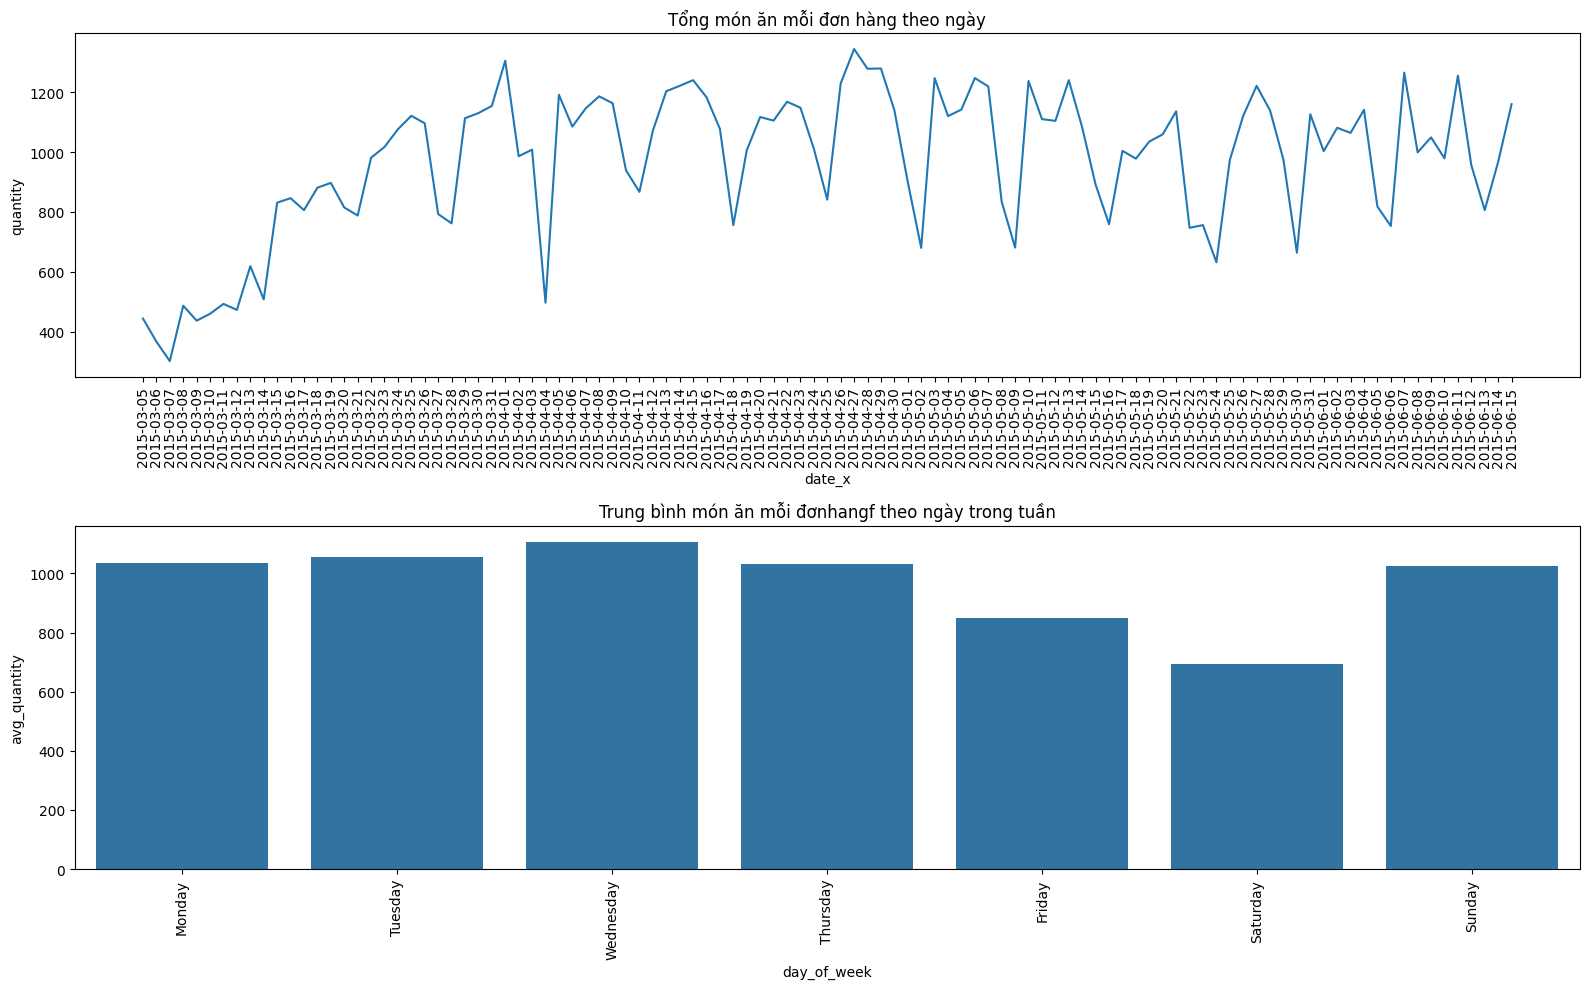

In [124]:
plt.figure(figsize=(16, 10))

plt.subplot(2, 1, 1)
sns.lineplot(data=groupby_day_quantity,
             x='date_x',
             y='quantity')
plt.xticks(rotation=90, ha='center')
plt.title("Tổng món ăn mỗi đơn hàng theo ngày")

plt.subplot(2, 1, 2)
sns.barplot(data=groupby_day_of_week_quantity,
             x='day_of_week',
             y='avg_quantity',
             order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xticks(rotation=90, ha='center')
plt.title("Trung bình món ăn mỗi đơnhangf theo ngày trong tuần")

plt.tight_layout()
plt.show()

### 2.2.4 Loại hình đơn hàng (ăn tại chỗ, mang đi)

In [80]:
# Group by date
groupby_day_meallocation = merged_ordersale_menuitem_groupby.groupby(['date_x', 'day_of_week', 'MealLocation']).agg(quantity=('MealLocation', 'count')).reset_index()

# Group day_of_week
groupby_day_of_week_meallocation = groupby_day_meallocation.groupby(['day_of_week', 'MealLocation']).agg(avg_quantity=('quantity', 'mean')).reset_index()

#### 2.2.4.2 Thêm cột MealLocationText
Làm rõ ngữ cảnh

In [81]:
# Add column MealLocationText
groupby_day_meallocation['MealLocationText'] = groupby_day_meallocation['MealLocation'].apply(lambda x: 'Eat' if x == 0 else 'ToGo')
groupby_day_of_week_meallocation['MealLocationText'] = groupby_day_of_week_meallocation['MealLocation'].apply(lambda x: 'Eat' if x == 0 else 'ToGo')

In [82]:
groupby_day_meallocation.head()

,date_x,day_of_week,MealLocation,quantity,MealLocationText
0,2015-03-05,Thursday,0,168,Eat
1,2015-03-05,Thursday,1,9,ToGo
2,2015-03-06,Friday,0,135,Eat
3,2015-03-06,Friday,1,7,ToGo
4,2015-03-07,Saturday,0,102,Eat


In [83]:
groupby_day_of_week_meallocation.head()

,day_of_week,MealLocation,avg_quantity,MealLocationText
0,Friday,0,254.266667,Eat
1,Friday,1,72.200000,ToGo
2,Monday,0,351.733333,Eat
3,Monday,1,80.733333,ToGo
4,Saturday,0,200.933333,Eat


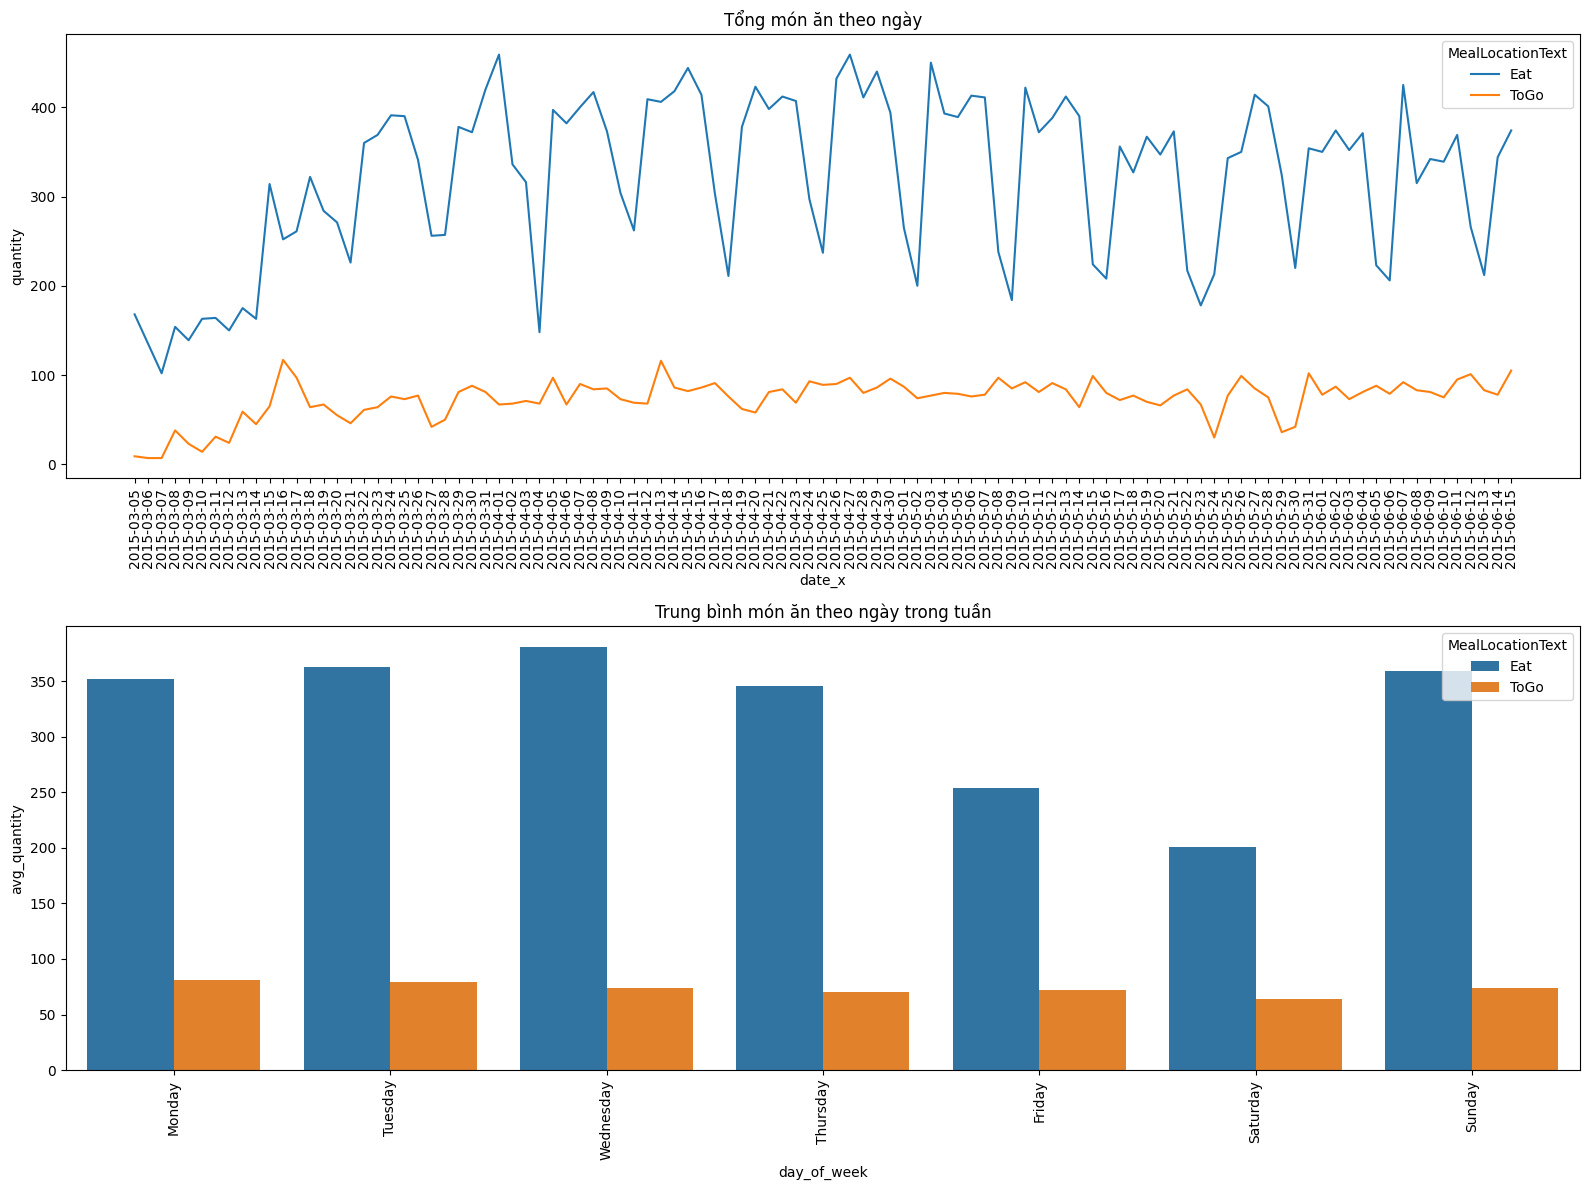

In [88]:
plt.figure(figsize=(16, 12))

plt.subplot(2, 1, 1)
sns.lineplot(data=groupby_day_meallocation,
             x='date_x',
             y='quantity',
             hue='MealLocationText')
plt.xticks(rotation=90, ha='center')
plt.title("Tổng món ăn theo ngày")

plt.subplot(2, 1, 2)
sns.barplot(data=groupby_day_of_week_meallocation,
             x='day_of_week',
             y='avg_quantity',
             hue='MealLocationText',
             order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xticks(rotation=90, ha='center')
plt.title("Trung bình món ăn theo ngày trong tuần")

plt.tight_layout()
plt.show()

Note: Từ các phân tích số lượng đơn hàng, số lượng món ăn mỗi đơn hàng, loại hình đơn hàng đều có tính chu kỳ tăng dần từ thứ hai tới thứ 5 và giảm dần tới thứ 7 rồi tăng lại từ chủ nhật. Ngoại trừ phân tích doanh thu trung bình mỗi đơn, điều này cho thấy có thể các đơn hàng ngày thứ 7 có các món có giá trị cao trong đơn hàng.

Nextstep:
- Phân tích thêm từng cửa hàng để xem có phải là pattern chung không.
- Phân tích các món ăn được đặt nhiều ở thứ 7 so với các món ăn của các ngày trong tuần (danh mục món ăn)

### 2.2.5 Top các món ăn được đặt theo các ngày trong tuần

In [168]:
pd.options.display.float_format = '{:.2f}'.format
df_menuitem.columns

Index(['MD5KEY_MENUITEM', 'MD5KEY_ORDERSALE', 'CategoryDescription',
       'DepartmentDescription', 'Description', 'StoreNumber', 'TaxAmount',
       'AdjustedPrice', 'DiscountAmount', 'Price', 'Quantity', 'PLU', 'Id',
       'date', 'SalesAmount', 'day_of_week'],
      dtype='object')

#### 2.2.5.1 Kiểm tra danh mục món ăn ảnh hưởng tới doanh thu

In [191]:
# Groupby day CategoryDescription
groupby_day_CategoryDescription = df_menuitem.groupby(['date', 'day_of_week', 'CategoryDescription'], observed=True).agg(
  price=('Price', 'mean'),
  quantity=('Quantity', 'sum'),
  revenue=('SalesAmount', 'sum')
).sort_values(by='revenue', ascending=False).reset_index()

print(groupby_day_CategoryDescription['revenue'].sum())

groupby_day_CategoryDescription['Percentage'] = groupby_day_CategoryDescription['revenue'] / groupby_day_CategoryDescription['revenue'].sum() * 100

groupby_day_CategoryDescription

422607.56999999995


,date,day_of_week,CategoryDescription,price,quantity,revenue,Percentage
0,2015-05-16,Saturday,Footlong,6.61,271,39286.67,9.30
1,2015-05-23,Saturday,Footlong,6.78,216,16588.68,3.93
2,2015-03-21,Saturday,Footlong,6.75,200,4508.68,1.07
3,2015-05-23,Saturday,Chips,1.13,159,4093.37,0.97
4,2015-03-21,Saturday,6 Inch,4.41,145,2560.98,0.61
...,...,...,...,...,...,...,...
1318,2015-04-20,Monday,Other Misc,0.78,2,1.20,0.00
1319,2015-03-06,Friday,Other Misc,1.25,1,1.16,0.00
1320,2015-04-27,Monday,Other Misc,1.50,1,1.15,0.00
1321,2015-06-10,Wednesday,Other Misc,1.50,1,1.15,0.00


In [219]:
# Groupby day of week CategoryDescription
groupby_day_of_week_CategoryDescription = groupby_day_CategoryDescription.groupby(['day_of_week', 'CategoryDescription'], observed=True).agg(
  quantity=('quantity', 'mean'),
  revenue=('revenue', 'mean')
).sort_values(by='revenue', ascending=False).reset_index()

print(groupby_day_of_week_CategoryDescription['revenue'].sum())

groupby_day_of_week_CategoryDescription['Percentage'] = groupby_day_of_week_CategoryDescription['revenue'] / groupby_day_of_week_CategoryDescription['revenue'].sum() * 100

groupby_day_of_week_CategoryDescription

30493.34991008991


,day_of_week,CategoryDescription,quantity,revenue,Percentage
0,Saturday,Footlong,197.07,5159.35,16.92
1,Wednesday,Footlong,268.14,1849.41,6.06
2,Thursday,Footlong,247.20,1778.87,5.83
3,Friday,Footlong,231.47,1766.14,5.79
4,Tuesday,Footlong,253.71,1755.38,5.76
...,...,...,...,...,...
97,Monday,Other Misc,2.64,3.75,0.01
98,Monday,Hot Beverage,2.36,3.74,0.01
99,Sunday,Other Misc,2.50,3.42,0.01
100,Saturday,Hot Beverage,1.64,3.11,0.01


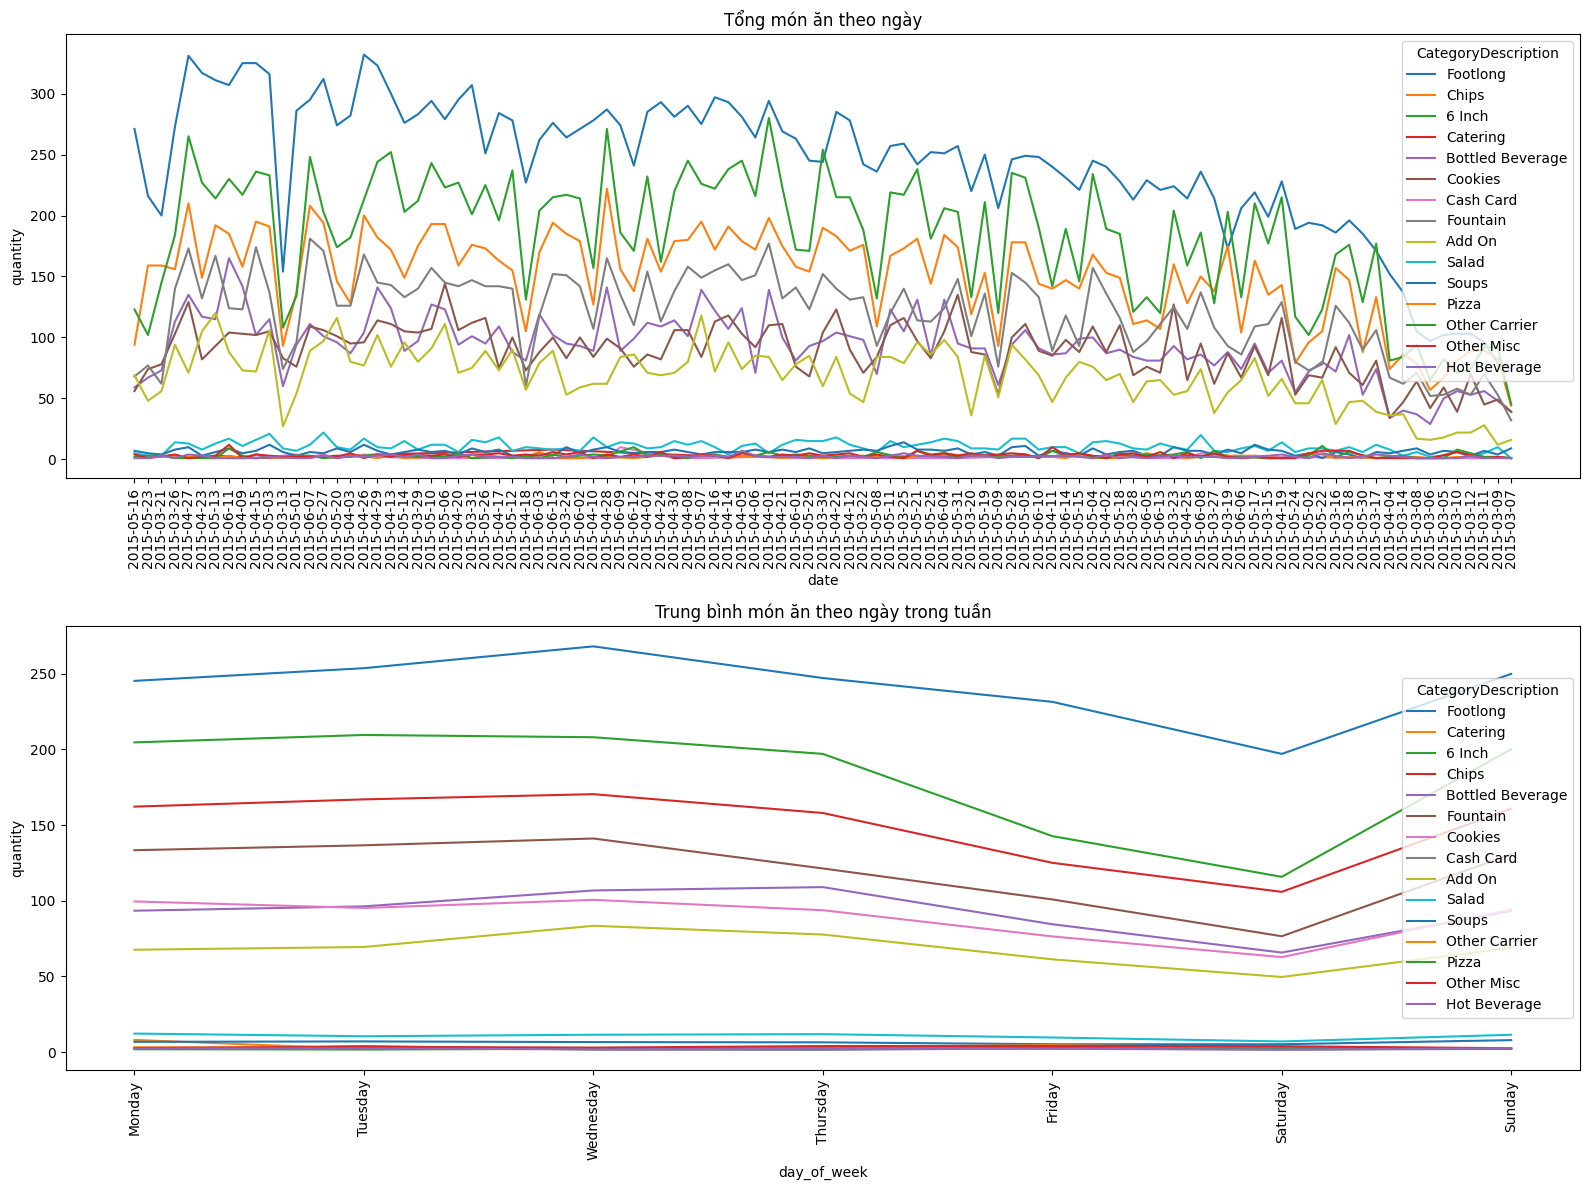

In [234]:
plt.figure(figsize=(16, 12))

plt.subplot(2, 1, 1)
sns.lineplot(data=groupby_day_CategoryDescription,
             x='date',
             y='quantity',
             palette='tab10',
             hue='CategoryDescription')
plt.xticks(rotation=90, ha='center')
plt.title("Tổng món ăn theo ngày")

plt.subplot(2, 1, 2)
sns.lineplot(data=groupby_day_of_week_CategoryDescription,
             x='day_of_week',
             y='quantity',
             hue='CategoryDescription',
             palette='tab10')
plt.xticks(rotation=90, ha='center')
plt.title("Trung bình món ăn theo ngày trong tuần")

plt.tight_layout()
plt.show()

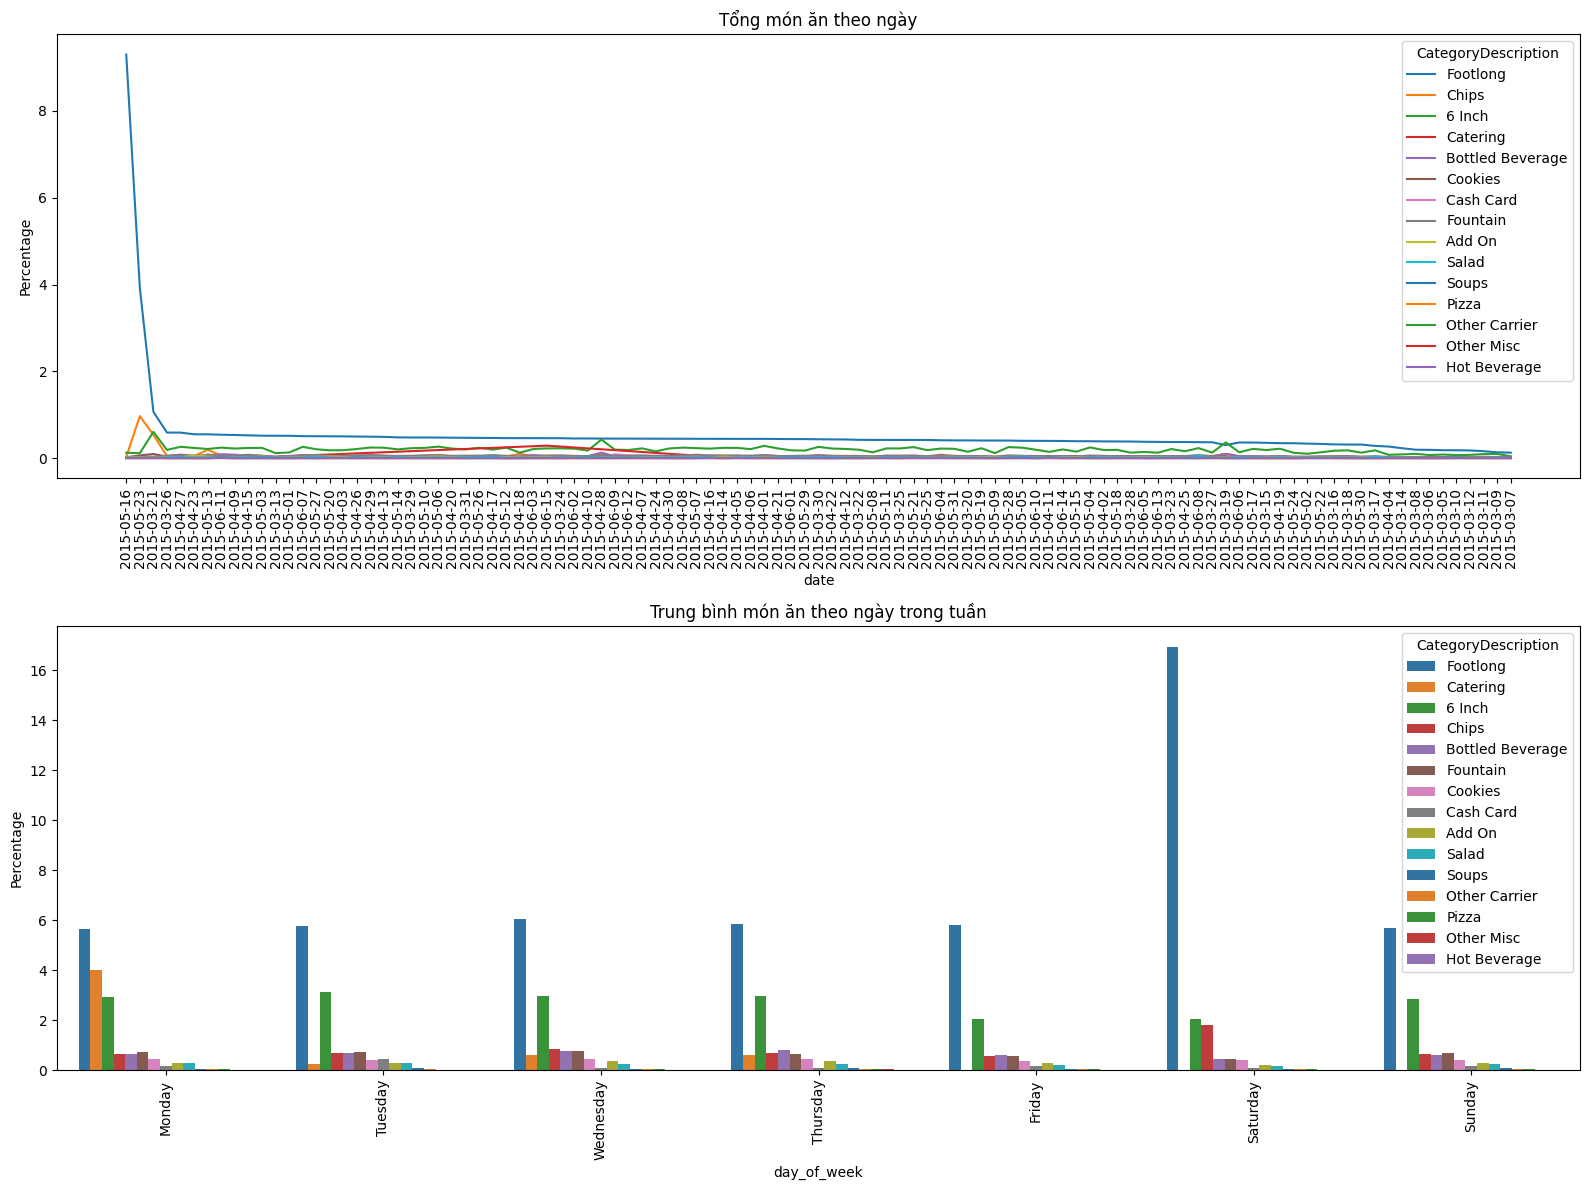

In [204]:
plt.figure(figsize=(16, 12))

plt.subplot(2, 1, 1)
sns.lineplot(data=groupby_day_CategoryDescription,
             x='date',
             y='Percentage',
             palette='tab10',
             hue='CategoryDescription')
plt.xticks(rotation=90, ha='center')
plt.title("Tổng món ăn theo ngày")

plt.subplot(2, 1, 2)
sns.barplot(data=groupby_day_of_week_CategoryDescription,
             x='day_of_week',
             y='Percentage',
             hue='CategoryDescription',
             palette='tab10',
             order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xticks(rotation=90, ha='center')
plt.title("Trung bình món ăn theo ngày trong tuần")

plt.tight_layout()
plt.show()

#### 2.2.5.2 Check các món ăn ảnh hưởng tới doanh thu

In [230]:
groupby_day_description = df_menuitem.groupby(['date', 'day_of_week', 'Description', 'Price'], observed=True).agg(
  quantity=('Quantity', 'sum'),
  revenue=('SalesAmount', 'sum')
).sort_values(by='revenue', ascending=False).reset_index()

groupby_day_description['Percentage'] = groupby_day_description['revenue'] / groupby_day_description['revenue'].sum() * 100

groupby_day_description = groupby_day_description.sort_values(by='Percentage', ascending=False)

groupby_day_description['cumsum'] = groupby_day_description['Percentage'].cumsum()

groupby_day_description[groupby_day_description['cumsum'] <= 20].nunique()

date           41
day_of_week     7
Description    23
Price          19
quantity       42
revenue        75
Percentage     75
cumsum         76
dtype: int64

In [222]:
groupby_day_of_week_description = groupby_day_description.groupby(['day_of_week', 'Description', 'Price'], observed=True).agg(
  quantity=('quantity', 'mean'),
  revenue=('revenue', 'mean')
).sort_values(by='revenue', ascending=False).reset_index()

groupby_day_of_week_description['Percentage'] = groupby_day_of_week_description['revenue'] / groupby_day_of_week_description['revenue'].sum() * 100

groupby_day_of_week_description.sort_values(by='Percentage', ascending=False)

,day_of_week,Description,Price,quantity,revenue,Percentage
0,Saturday,Turkey FtLong,6.75,21.93,3012.53,5.72
1,Saturday,Big Hot Pastrami FtLong,8.25,6.67,1723.65,3.27
2,Saturday,Chips,1.19,59.00,1105.28,2.10
3,Saturday,Ham 6 inch,4.25,11.00,696.48,1.32
4,Monday,Subway Fresh Fit SndPlt,38.00,4.00,608.00,1.15
...,...,...,...,...,...,...
3211,Sunday,Chicken Bcn Ranch FlatBd,4.75,1.00,0.00,0.00
3210,Tuesday,Steak & Chse FlatBd,4.75,1.00,0.00,0.00
3209,Tuesday,Ham Wrap,3.75,1.00,0.00,0.00
3208,Sunday,Chicken Parm FlatBd,4.50,1.33,0.00,0.00


/var/folders/dq/v_fjhwnn1d51xqk1b5hc753c0000gn/T/ipykernel_1034/918345733.py:22: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


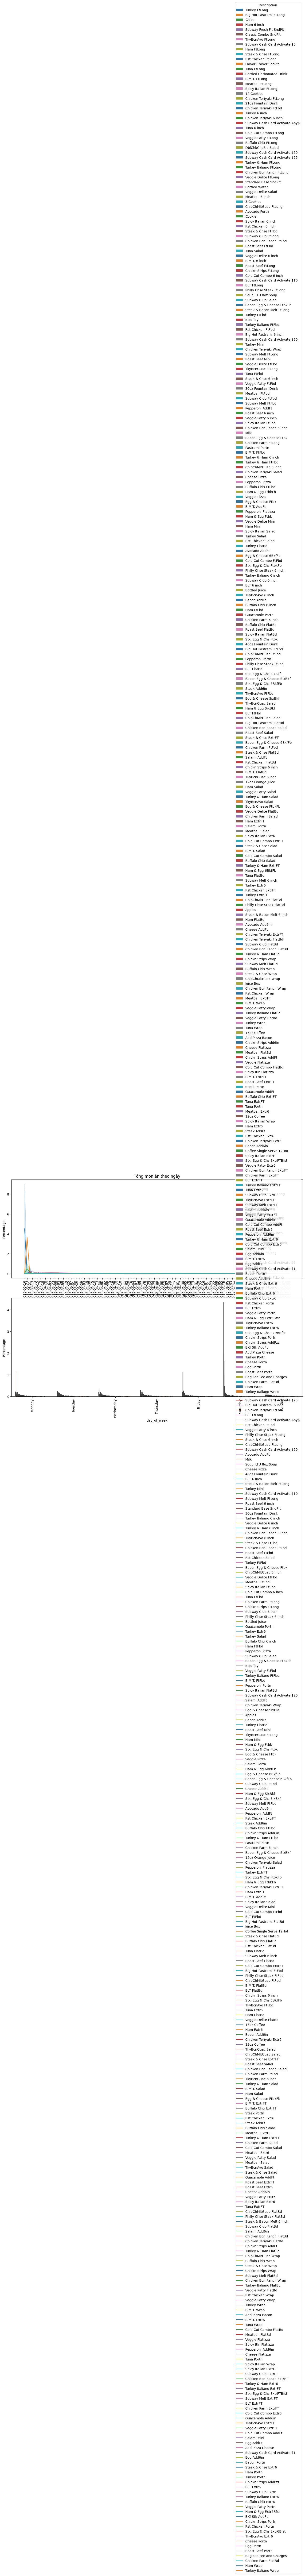

In [218]:
plt.figure(figsize=(16, 12))

# plt.subplot(2, 1, 1)
sns.lineplot(data=groupby_day_description,
             x='date',
             y='Percentage',
             palette='tab10',
             hue='Description')
plt.xticks(rotation=90, ha='center')
plt.title("Tổng món ăn theo ngày")

# plt.subplot(2, 1, 2)
# sns.barplot(data=groupby_day_of_week_description,
#              x='day_of_week',
#              y='Percentage',
#              hue='Description',
#              palette='tab10',
#              order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
# plt.xticks(rotation=90, ha='center')
# plt.title("Trung bình món ăn theo ngày trong tuần")

plt.tight_layout()
plt.show()